In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.weightstats import ztest


In [3]:
from utils import World, Rainfall, movmean

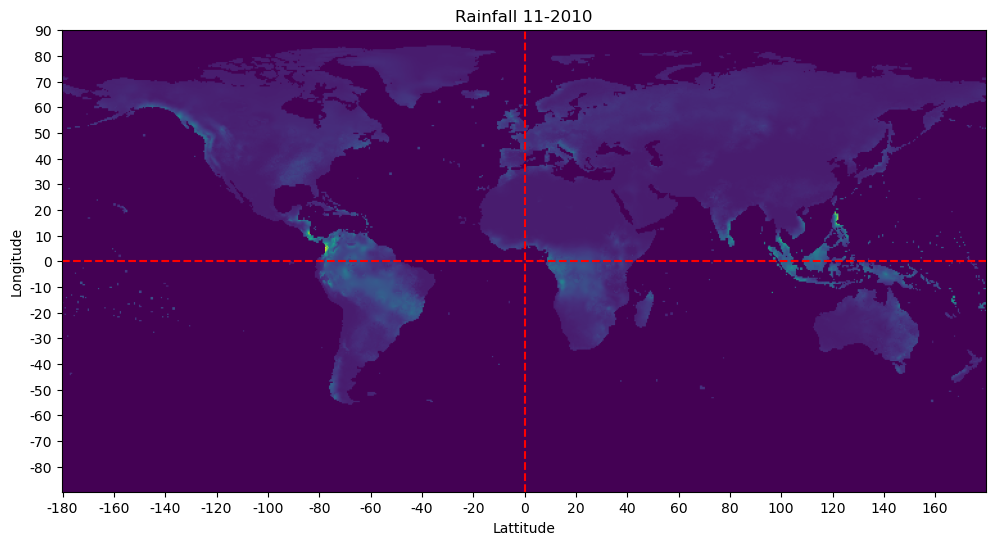

In [4]:
# fetch data
rainfall = Rainfall()
rainfall.fetch_data_years(1901, 2023, delete_file=True)

# get 2001 january for the entire world and plot
ax = rainfall.plot_month(11, 2010)
plt.show()

# Create the world object and create lookup array

In [5]:
# create the world object
world = World('tests/aux_files/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp')
world.create_lookup()

### Quick test to see if country selections make sense

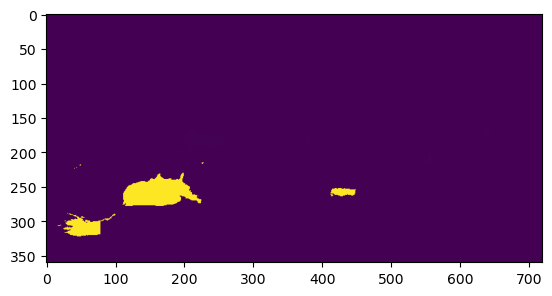

In [6]:
# quick test for selecting country
idx = world.get_grid_points_of_country(iso_code='TUR')
data = np.copy(rainfall.get_month(5, 2007))
data[idx] = 999999
idx = world.get_grid_points_of_country(iso_code='US1')
data[idx] = 999999
plt.imshow(data)
plt.show()

### Plot rainfall totals for Turkey and Syria, just as a test

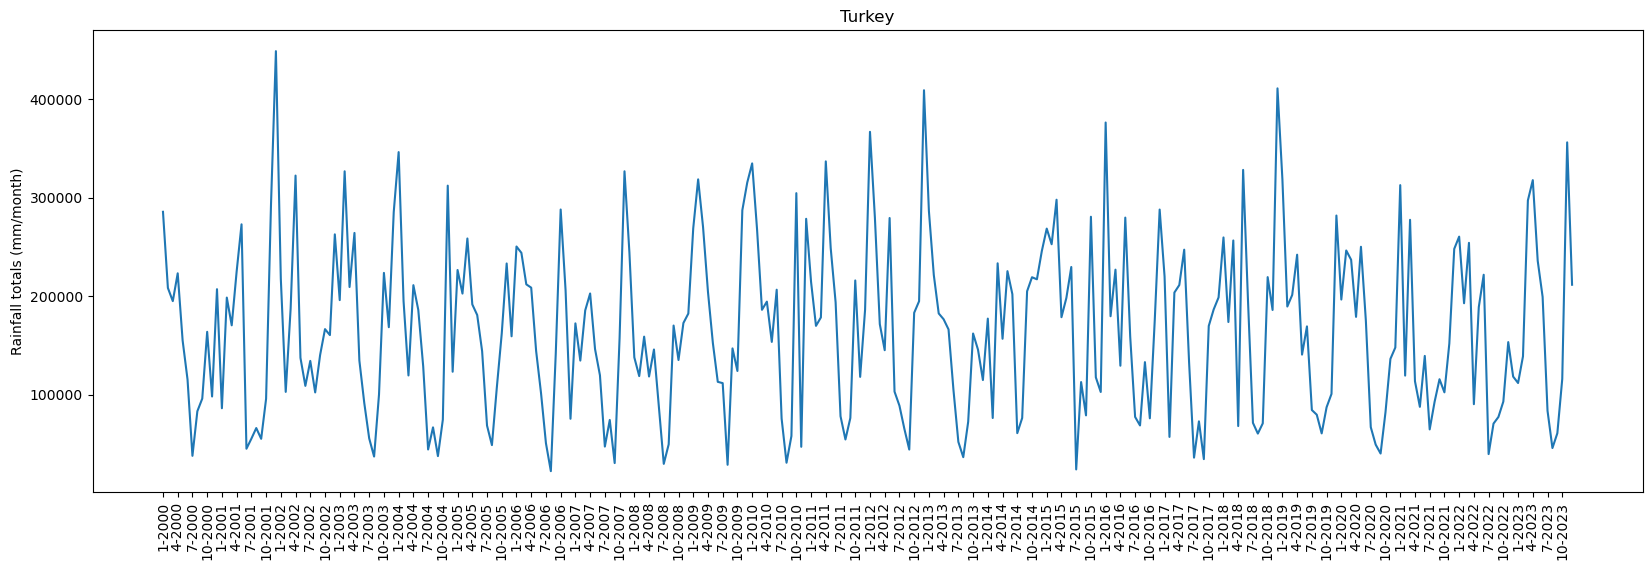

In [7]:
t, dates, totals = rainfall.get_country_total((1,12), (2000,2023),'TUR', world)
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(t, totals)
ax.set_xticks(t[::3])
ax.set_xticklabels(dates[::3], rotation=90)
ax.set_ylabel('Rainfall totals (mm/month)')
ax.set_title('Turkey')
plt.show()

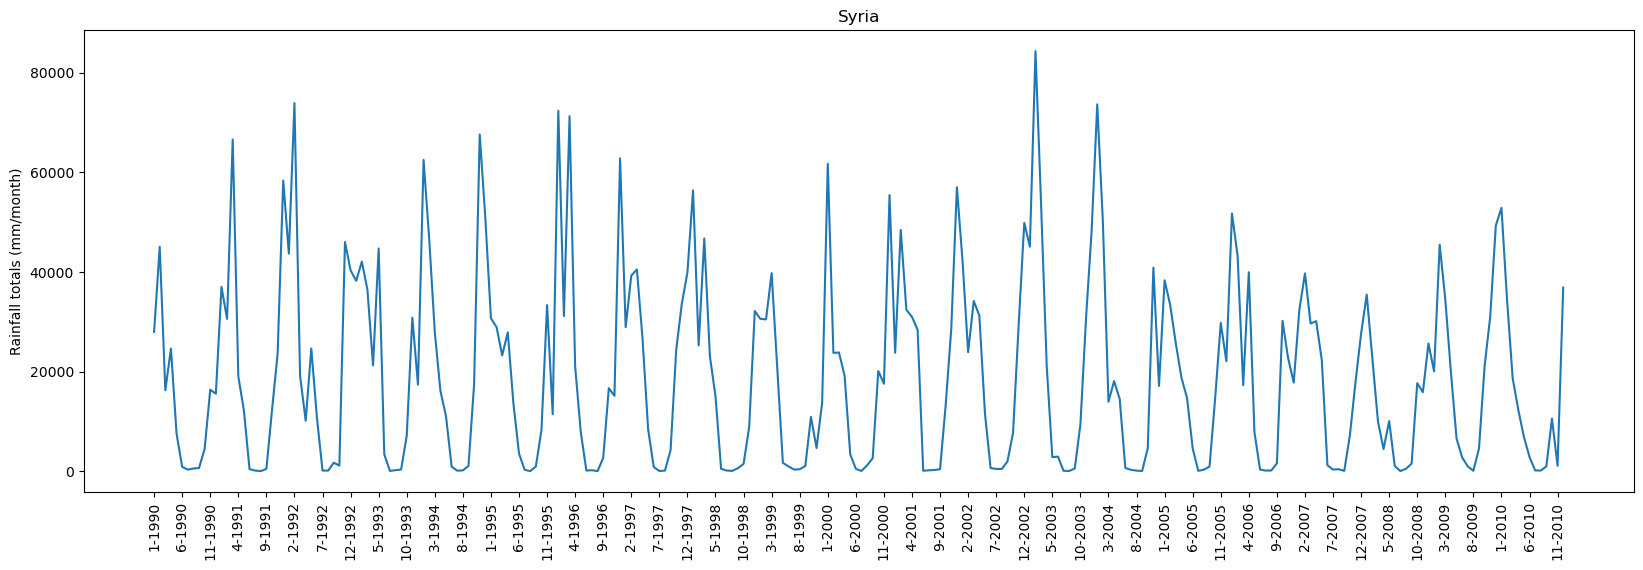

In [8]:
t, dates, totals = rainfall.get_country_total((1,12), (1990,2010),'SYR', world)
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(t, totals)
ax.set_xticks(t[::5])
ax.set_xticklabels(dates[::5], rotation=90)
ax.set_ylabel('Rainfall totals (mm/month)')
ax.set_title('Syria')
plt.show()

### Syria 6-month winter averages (November-April) as plotted in Fig.1 of [Kelley et al.](https://www.pnas.org/doi/epdf/10.1073/pnas.1421533112)

The orange line is a moving average with a window of 50 years, meant to depict the overall decrease trend starting around ~1990.

p-value for pre 1930s temperature to be larger is 0.07485028305619501, with a test statistic of 1.4405899331246035.


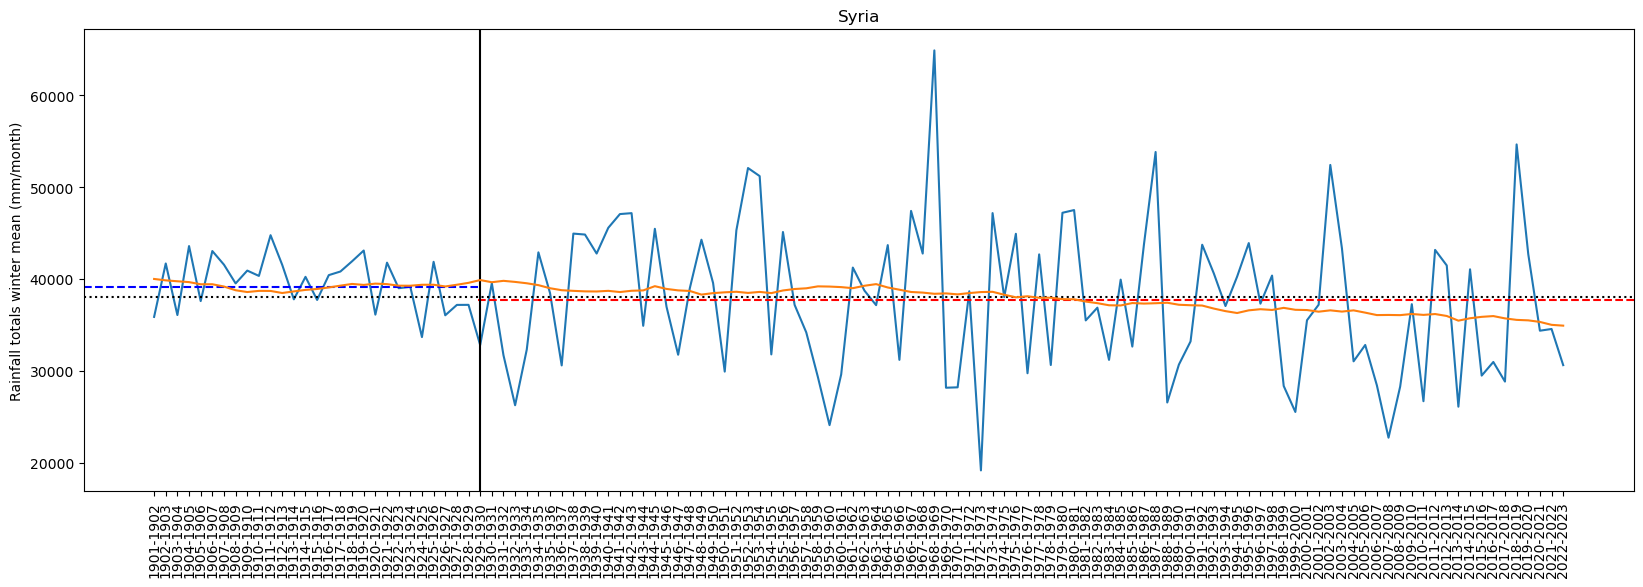

In [33]:
t, dates, winter_means = rainfall.get_country_winter_mean((1901,2023), 'SYR', world)

# quick hypothesis testing with H_0: mu_1=mu_2, H_a: mu_2>mu_1
pre_30s = winter_means[:31]
post_30s = winter_means[31:]
pop_mean_diff = np.mean(post_30s)-np.mean(pre_30s)
z, p = ztest(x1=pre_30s, x2=post_30s, alternative='larger', usevar='unequal')
print(f"p-value for pre 1930s temperature to be larger is {p}, with a test statistic of {z}.")

fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(t, winter_means)
ax.axhline(np.mean(winter_means), color='k', linestyle='dotted')
ax.axhline(np.mean(winter_means[:31]), color='b', linestyle='dashed', xmax=31/len(dates))
ax.axhline(np.mean(winter_means[31:]), color='r', linestyle='dashed', xmin=31/len(dates))
ax.axvline(28, color='k')
ax.plot(t, movmean(winter_means, window=50))

ax.set_xticks(t)
ax.set_xticklabels(dates, rotation=90)
ax.set_ylabel('Rainfall totals winter mean (mm/month)')
ax.set_title('Syria')
plt.show()

Try different cutoffs for the year for the z-test. (This is probably p-hacking)

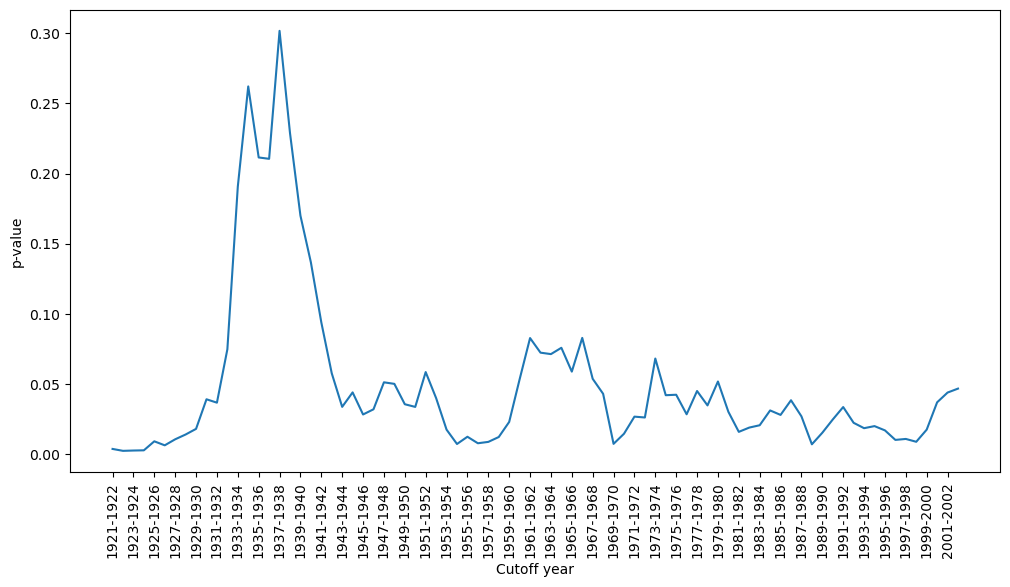

In [34]:
cutoffs = []
pvals = []
margin = 20
for i in range(margin,len(winter_means)-margin):
    pre = winter_means[:i]
    post = winter_means[i:]
    z, p = ztest(x1=pre, x2=post, alternative='larger', usevar='unequal')
    cutoffs.append(i)
    pvals.append(p)

fig, ax = plt.subplots(figsize=(12,6))
ax.plot(cutoffs, pvals)
ax.set_xlabel('Cutoff year')
ax.set_ylabel('p-value')
ax.set_xticks(cutoffs[::2])
ax.set_xticklabels(dates[margin:-margin][::2], rotation=90)
plt.show()

Same for Turkey, just out of curiosity. Note that a similar trend exists, but the total rainfall is an order of magnitude larger. This suggests to me that maybe if the total rainfall is large enough, the economical impacts of a drought may be more robust to rainfall variation. 

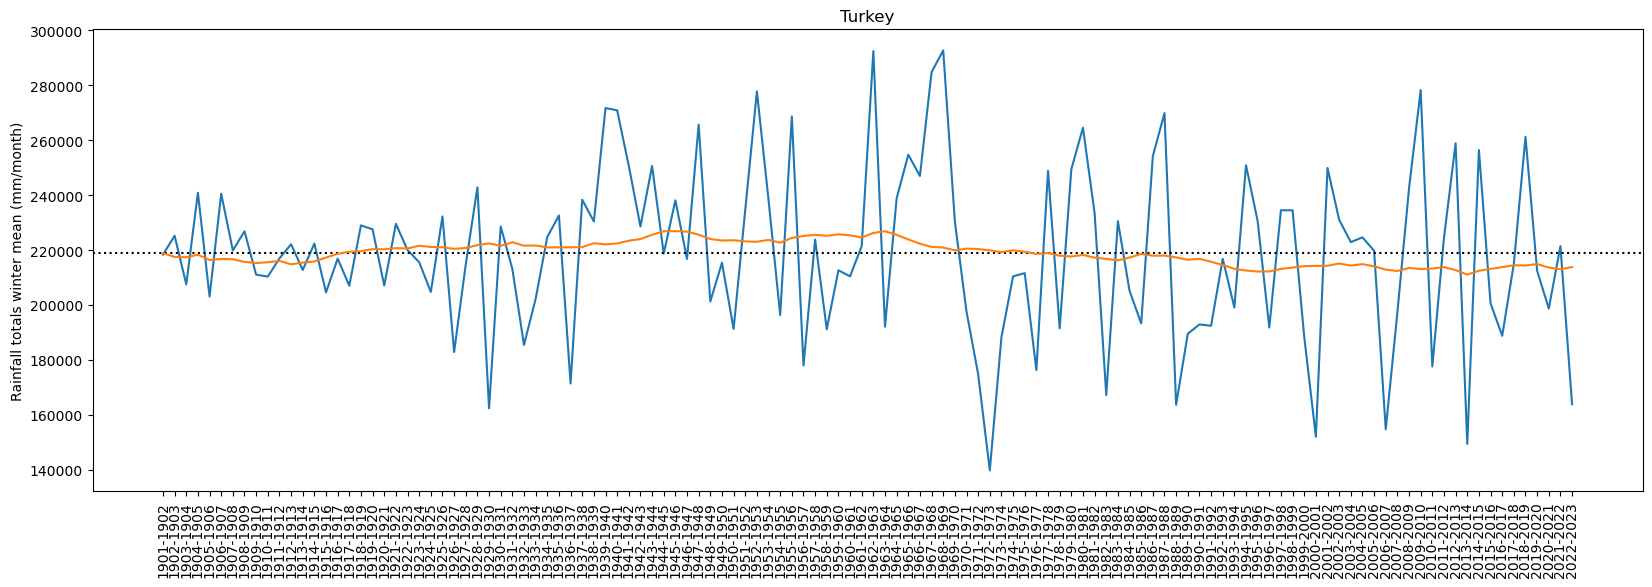

In [11]:
t, dates, winter_means = rainfall.get_country_winter_mean((1901,2023), 'TUR', world)
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(t, winter_means)
ax.axhline(np.mean(winter_means), color='k', linestyle='dotted')
ax.plot(t, movmean(winter_means, window=50))
ax.set_xticks(t)
ax.set_xticklabels(dates, rotation=90)
ax.set_ylabel('Rainfall totals winter mean (mm/month)')
ax.set_title('Turkey')
plt.show()

Rainfall variation (as numerical differentiation)

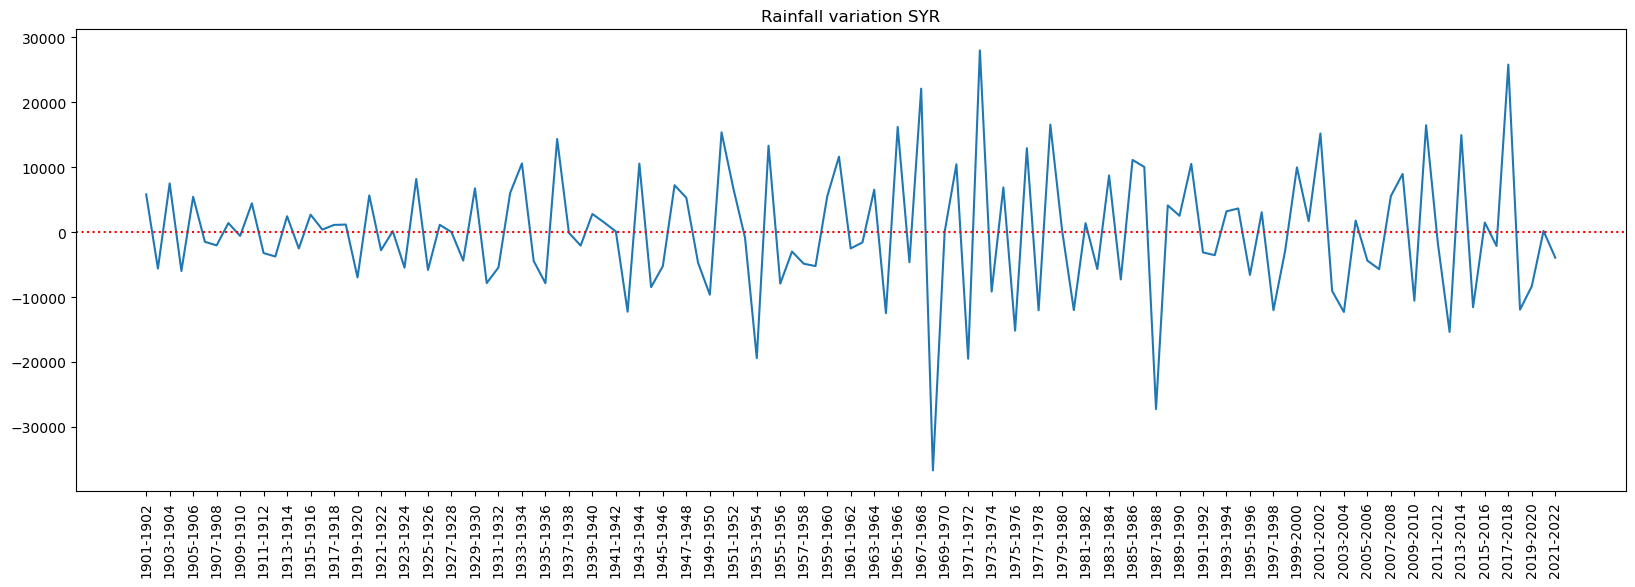

In [12]:
t, dates, winter_means = rainfall.get_country_winter_mean((1901,2023), 'SYR', world)
variation = np.diff(winter_means)
fig, ax = plt.subplots(figsize=(20,6))
ax.plot(t[:-1], variation)
ax.set_xticks(t[::2])
ax.set_xticklabels(dates[::2], rotation=90)
ax.axhline(0, color='r', linestyle='dotted')
ax.set_title('Rainfall variation SYR')
plt.show()

Compare with GDP

In [13]:
df = pd.read_csv("https://ourworldindata.org/grapher/gdp-worldbank-constant-usd.csv?v=1&csvType=full&useColumnShortNames=true", storage_options = {'User-Agent': 'Our World In Data data fetch/1.0'})
df.head(5)

,Entity,Code,Year,ny_gdp_mktp_kd
0,Afghanistan,AFG,2000,6.206548e+09
1,Afghanistan,AFG,2001,5.621148e+09
2,Afghanistan,AFG,2002,7.228796e+09
3,Afghanistan,AFG,2003,7.867264e+09
4,Afghanistan,AFG,2004,7.978516e+09


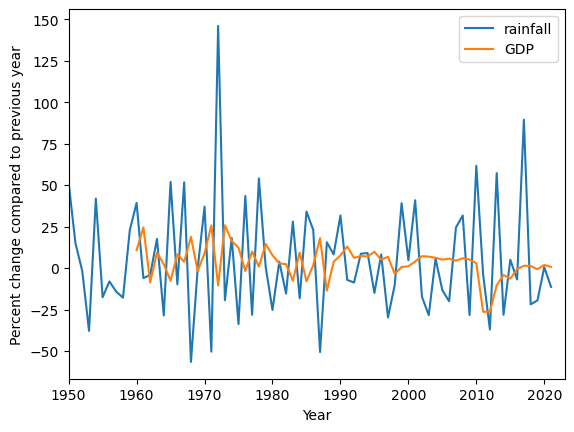

In [14]:
year = df[df['Code'] == 'SYR'].Year

gdp = df[df['Code'] == 'SYR'].ny_gdp_mktp_kd
gdp_var = 100*np.diff(gdp)/gdp[:-1]

t, dates, winter_means = rainfall.get_country_winter_mean((1901,2023), 'SYR', world)
variation = 100*np.diff(winter_means)/winter_means[:-1]
tx = np.arange(1901, 2022) 

plt.plot(tx, variation, label='rainfall')
plt.plot(year[:-1], gdp_var, label='GDP')
plt.xlabel('Year')
plt.ylabel('Percent change compared to previous year')
plt.xlim(1950,2023)
plt.legend()
plt.show()

[[0.         0.03477456]] 0.015191192251121977


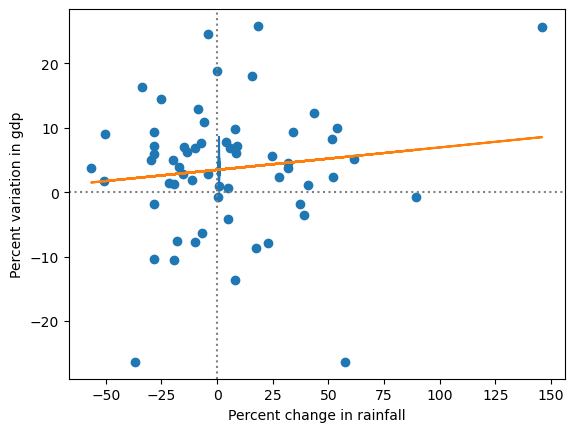

In [ ]:
from sklearn.linear_model import LinearRegression

year = df[df['Code'] == 'SYR'].Year

gdp = df[df['Code'] == 'SYR'].ny_gdp_mktp_kd
gdp_var = 100*np.diff(gdp)/gdp[:-1]

t, dates, winter_means = rainfall.get_country_winter_mean((1960,2023), 'SYR', world)
variation = 100*np.diff(winter_means)/winter_means[:-1]
tx = np.arange(1961, 2022)

plt.scatter(variation[1:], gdp_var[:-1])
plt.xlabel('Percent change in rainfall')
plt.ylabel('Percent variation in gdp')
plt.axhline(0, color='gray', linestyle='dotted')
plt.axvline(0, color='gray', linestyle='dotted')

X = np.hstack((np.ones((len(variation[1:]), 1)), variation[1:].reshape(-1, 1)))
y = gdp_var[:-1].to_numpy().reshape(-1, 1)
reg = LinearRegression().fit(X, y)
print(reg.coef_, reg.score(X, y))
plt.plot(X, reg.predict(X))
plt.show()

[[   0.       7741.646808]] 0.002775611096733299


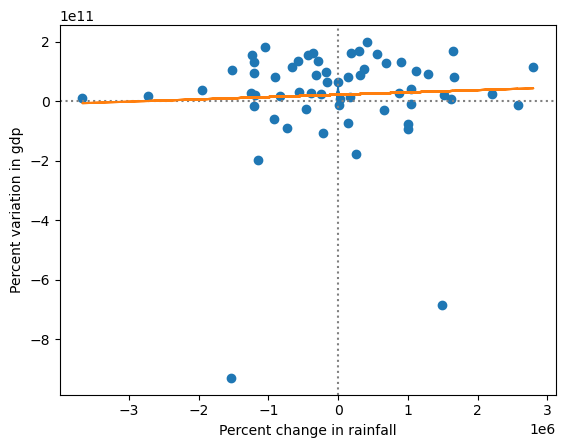

In [36]:
year = df[df['Code'] == 'SYR'].Year

gdp = df[df['Code'] == 'SYR'].ny_gdp_mktp_kd
gdp_var = 100*np.diff(gdp)

t, dates, winter_means = rainfall.get_country_winter_mean((1960,2023), 'SYR', world)
variation = 100*np.diff(winter_means)

plt.scatter(variation[1:], gdp_var[:-1])
plt.xlabel('Percent change in rainfall')
plt.ylabel('Percent variation in gdp')
plt.axhline(0, color='gray', linestyle='dotted')
plt.axvline(0, color='gray', linestyle='dotted')

X = np.hstack((np.ones((len(variation[1:]), 1)), variation[1:].reshape(-1, 1)))
y = gdp_var[:-1].reshape(-1, 1)
reg = LinearRegression().fit(X, y)
print(reg.coef_, reg.score(X, y))
plt.plot(X, reg.predict(X))
plt.show()

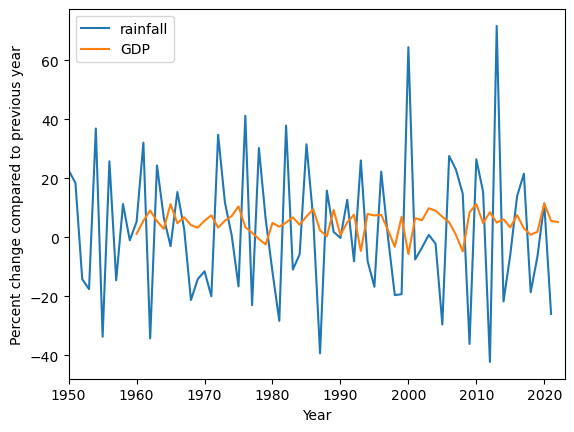

In [ ]:
year = df[df['Code'] == 'TUR'].Year

gdp = df[df['Code'] == 'TUR'].ny_gdp_mktp_kd
gdp_var = 100*np.diff(gdp)/gdp[:-1]

t, dates, winter_means = rainfall.get_country_winter_mean((1901,2023), 'TUR', world)
variation = 100*np.diff(winter_means)/winter_means[:-1]
tx = np.arange(1901, 2022)

plt.plot(tx, variation, label='rainfall')
plt.plot(year[:-1], gdp_var, label='GDP')
plt.xlabel('Year')
plt.ylabel('Percent change compared to previous year')
plt.xlim(1950,2023)
plt.legend()
plt.show()